# **Data Preprocessing**

## Import thư viện

In [1]:
# Thư viện xử lý
import os
import torch
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

# Thư viện cân bằng
from imblearn.over_sampling import SMOTE

# Thư viện chuẩn hóa
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

from concurrent.futures import ThreadPoolExecutor

## Đọc dữ liệu từ file

In [2]:
df_train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

## Kiểm tra thông tin về tập dữ liệu

#### Xem thông tin về các cột đặc trưng

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

#### Kiểm tra giá trị null

In [5]:
df_train.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

#### Kiểm tra trùng lặp

In [6]:
df_train.duplicated().sum()

0

#### Xử lý lớp nhãn

## Chuẩn hóa các đặc trưng chữ về kiểu dữ liệu số

### Phương pháp One-Hot Encoding

In [3]:
# Thêm cột "dataset" để phân biệt
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

# Kết hợp train và test
df_combined = pd.concat([df_train, df_test], axis=0)

# Áp dụng one-hot encoding
df_combined = pd.get_dummies(df_combined, columns=['proto', 'service', 'state'])

# Tách lại thành train và test
df_train = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
df_test = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)

#### Chuyển kiểu dữ các cột đã mã hóa thành int

In [4]:
columns = df_train.columns
one_hot_columns = [col for col in columns if 'proto_' in col or 'service_' in col or 'state_' in col]

df_train[one_hot_columns] = df_train[one_hot_columns].astype(int)
df_test[one_hot_columns] = df_test[one_hot_columns].astype(int)

## Phân loại nhị phân

### Cân bằng tỷ lệ phân bố ở lớp nhãn, áp dụng Partial SMOTE (tăng nhẹ)

In [14]:
df_train['label'].value_counts()

label
1    119341
0     56000
Name: count, dtype: int64

#### Cân bằng lớp nhãn

In [5]:
df_class1 = df_train[df_train['label'] == 1]  # Lọc các mẫu của lớp 1
df_class0 = df_train[df_train['label'] == 0]  # Lọc các mẫu của lớp 0

# Lấy mẫu ngẫu nhiên 80% của lớp 1
df_class1_downsampled = df_class1.sample(frac=0.8, random_state=42).reset_index(drop=True)

# Kết hợp lại với lớp 0
df_train = pd.concat([df_class1_downsampled, df_class0])

In [11]:
df_train["label"].value_counts()

#### Tách lớp nhãn

In [6]:
output_data_train = df_train['label']
output_data_test = df_test['label']

df_train = df_train.drop(columns=['attack_cat','label'])
df_test = df_test.drop(columns=['attack_cat', 'label'])

In [7]:
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Tăng lớp 0 lên 80% lớp 1
df_train_resampled, label_resampled = smote.fit_resample(df_train, output_data_train)
df_label_balanced = pd.concat([pd.DataFrame(df_train_resampled, columns=df_train.columns),
                               pd.Series(label_resampled, name='label')], axis=1)

output_data_train = df_label_balanced["label"]
df_train = df_label_balanced.drop(columns=['label'])

In [10]:
output_data_train.value_counts()

label
1    95473
0    76378
Name: count, dtype: int64

## Phân loại 

### Xử lý lớp nhãn

In [5]:
df_train = df_train.drop(columns=['label'])
df_test = df_test.drop(columns=['label'])

attack_order = [
    'Normal', 'Generic', 'Exploits', 'Fuzzers',
    'DoS', 'Reconnaissance', 'Analysis', 'Backdoor',
    'Shellcode', 'Worms'
]

# Tạo mapping theo thứ tự
attack_mapping = {attack: i for i, attack in enumerate(attack_order)}


df_train = df_train.copy()
df_test = df_test.copy()

df_train['label'] = df_train['attack_cat'].map(attack_mapping)
df_test['label'] = df_test['attack_cat'].map(attack_mapping)

output_data_test = df_test['label']

df_train = df_train.drop(columns=['attack_cat'])
df_test = df_test.drop(columns=['attack_cat', 'label'])

In [6]:
output_data_train = df_train['label']
df_train = df_train.drop(columns=['label'])

In [17]:
df_train["label"].value_counts()

label
0    56000
1    40000
2    33393
3    18184
4    12264
5    10491
6     2000
7     1746
8     1133
9      130
Name: count, dtype: int64

In [17]:
output_data_test.value_counts()

### Cân bằng lớp nhãn

In [6]:
# Tạo đối tượng SMOTE
smote = SMOTE(sampling_strategy={6: 3500, 7: 3000, 8: 2500, 9: 1200}, random_state=42)  # Oversample lớp R2L và U2R đến 5000 mẫu

X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

# Áp dụng SMOTE
df_train, output_data_train = smote.fit_resample(X_train, y_train)

In [16]:
output_data_train.value_counts()

label
0    56000
1    40000
2    33393
3    18184
4    12264
5    10491
6     3500
7     3000
8     2500
9     1200
Name: count, dtype: int64

## Đánh giá mức độ quan trọng của các đặc trưng

In [8]:
# Khởi tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(df_train, output_data_train)

# Lấy mức độ quan trọng của các feature
importances = model.feature_importances_

# Khởi tạo output dễ dàng nhìn thấy kết quả
feature_importance_df = pd.DataFrame({
    'Feature': df_train.columns,
    'Importance': importances
})

# Sắp xếp các feature theo mức độ quan trọng
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [11]:
print(feature_importance_df[:60])

               Feature  Importance
0                   id    0.205132
24               smean    0.053046
4               sbytes    0.047694
7                 sttl    0.046530
38          ct_srv_dst    0.040741
33      ct_dst_src_ltm    0.036938
28          ct_srv_src    0.036122
175        service_dns    0.034210
6                 rate    0.031288
9                sload    0.029602
31    ct_src_dport_ltm    0.026890
32    ct_dst_sport_ltm    0.024830
173          service_-    0.022914
5               dbytes    0.022594
29        ct_state_ttl    0.021114
14              dinpkt    0.020536
25               dmean    0.020049
10               dload    0.019104
8                 dttl    0.018352
37          ct_src_ltm    0.016589
1                  dur    0.016539
13              sinpkt    0.015746
22              synack    0.015261
30          ct_dst_ltm    0.015144
23              ackdat    0.014532
159          proto_udp    0.014319
21              tcprtt    0.013721
3                dpk

## Thực hiện nhân bản một số đặc trưng

### Kiểm tra số cột đặc trưng đang có

In [20]:
df_train.shape[1]

197

In [21]:
df_test.shape[1]

197

### Lấy một số đặc trưng để nhân bản

In [9]:
num_features = 50

In [10]:
feature_importance_50 = feature_importance_df[:num_features]

In [11]:
important_features = feature_importance_50['Feature'].tolist()

# Tính toán số lượng cần nhân bản
# Ví dụ số lượng đặc trưng chọn nhân bản: 50
# num_copies = (1024 - 123) // 50 = 18 lần
# remainder = (1024 - 123) // 50 = 1 (có 1 đặc trưng nhân bản thêm 1 lần)

num_copies = (1024 - 197) // len(important_features)
remainder = (1024 - 197) % len(important_features)

# --------- Xử lý nhân bản các đặc trưng cho tập train---------
expanded_features_list = []
for feature in important_features:
    for _ in range(num_copies):
        expanded_features_list.append(df_train[feature].rename(f"{feature}_copy_{_}"))

# Phân phối phần còn lại
for i in range(remainder):
    feature = important_features[i]
    expanded_features_list.append(df_train[feature].rename(f"{feature}_extra_copy"))

expanded_features_train = pd.concat([df_train] + expanded_features_list, axis=1)
df_train = expanded_features_train.iloc[:, :1024]

# ------- Nhân bản các đặc trưng quan trọng cho tập test-----------
expanded_features_list_test = []

for feature in important_features:
    for _ in range(num_copies):
         expanded_features_list_test.append(df_test[feature].rename(f"{feature}_copy_{_}"))

# Phân phối phần còn lại
for i in range(remainder):
    feature = important_features[i]
    expanded_features_list_test.append(df_test[feature].rename(f"{feature}_extra_copy"))

# Gộp tất cả cột mới vào DataFrame ban đầu
expanded_features_test = pd.concat([df_test] + expanded_features_list_test, axis=1)
df_test = expanded_features_test.iloc[:, :1024]  # Chỉ lấy 1024 cột

In [11]:
df_train.shape[1]

1024

## Áp dụng MinMaxScaler() đưa dữ liệu về cùng quy mô

In [27]:
# scaler_Min_Max = MinMaxScaler(feature_range=(0, 255))
# # scaler_Standard = Stand ardScaler()

# input_data_train = scaler_Min_Max.fit_transform(df_train)
# input_data_test = scaler_Min_Max.transform(df_test)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

input_data_train  = scaler.fit_transform(df_train)
input_data_test = scaler.transform(df_test)

In [25]:
input_data_train[:10]

array([[-1.73204093, -0.19102881, -0.10445581, ..., -0.03955687,
        -0.18976806, -0.10717012],
       [-1.73202117, -0.10948479, -0.04601353, ..., -0.03955687,
        -0.18976806, -0.10717012],
       [-1.73200142,  0.04069922, -0.08984524, ..., -0.03955687,
        -0.18976806, -0.10717012],
       ...,
       [-1.73190263, -0.12928625, -0.07523467, ..., -0.03955687,
        -0.18976806, -0.10717012],
       [-1.73188288, -0.12599609, -0.07523467, ..., -0.03955687,
        -0.18976806, -0.10717012],
       [-1.73186312, -0.16985533, -0.07523467, ..., -0.03955687,
        -0.18976806, -0.10717012]])

# **Chuyển đổi tập dữ liệu thành ảnh**


In [13]:
import os
import random
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

## Hàm chuyển đổi dữ liệu thành ảnh

### Xử lý hình ảnh 32x32

In [14]:
def convert_and_save_image(row, index, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    if len(row) < 1024:
        padded_row = np.pad(row, (0, 1024 - len(row)), mode='constant', constant_values=0)
    else:
        padded_row = row[:1024]  # Cắt bỏ phần thừa

    normalized_row = (padded_row - np.min(padded_row)) / (np.max(padded_row) - np.min(padded_row)) 
    scaled_row = normalized_row * 255
    
    # Hình thành ma trận kích thước 32x32
    image_data_reshaped = scaled_row.reshape((32, 32))

    # Tạo ảnh màu với 3 kênh
    image_rgb = np.stack([image_data_reshaped] * 3, axis=-1)

    image = Image.fromarray(image_rgb.astype(np.uint8))
    image_path = os.path.join(output_dir, f"image{index}.jpg")
    try:
        image.save(image_path)
    except Exception as e:
        print(f"Lỗi thao tác {index}: {e}")

##Thực hiện xử lý đa luồng

In [15]:
def process_dataset(dataset, output_dir):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(convert_and_save_image, row, i, output_dir) for i, row in enumerate(dataset)]
        for future in futures:
            future.result()

##Trích ra số lượng mẫu

### Phân loại nhị phân

Trích ra số lượng mẫu

In [16]:
train_normal = list(np.where(output_data_train == 0)[0])
train_attack = list(np.where(output_data_train == 1)[0])
test_normal = list(np.where(output_data_test == 0)[0])
test_attack = list(np.where(output_data_test == 1)[0])
np.random.seed(42)
random.seed(42)

data_train_normal = input_data_train[random.sample(train_normal, 20000)]
data_train_attack = input_data_train[random.sample(train_attack, 35000)]
data_test_normal = input_data_test[random.sample(test_normal, 2300)]
data_test_attack = input_data_test[random.sample(test_attack, 4000)]

In [34]:
# output_data_test.value_counts()

Lấy hết mẫu để huấn luyện

In [21]:
train_normal = list(np.where(output_data_train == 0)[0])
train_attack = list(np.where(output_data_train == 1)[0])
test_normal = list(np.where(output_data_test == 0)[0])
test_attack = list(np.where(output_data_test == 1)[0])

data_train_normal = input_data_train[train_normal]
data_train_attack = input_data_train[train_attack]
data_test_normal = input_data_test[test_normal]
data_test_attack = input_data_test[test_attack]

#### Xử lý và lưu trữ ảnh

In [17]:
train_normal_dir = "/kaggle/working/unsw_nb15/train/normal/"
train_anomaly_dir = "/kaggle/working/unsw_nb15/train/attack/"
test_normal_dir = "/kaggle/working/unsw_nb15/test/normal/"
test_anomaly_dir = "/kaggle/working/unsw_nb15/test/attack/"

process_dataset(data_train_normal, train_normal_dir)
process_dataset(data_train_attack, train_anomaly_dir)
process_dataset(data_test_normal, test_normal_dir)
process_dataset(data_test_attack, test_anomaly_dir)

### Phân loại đa lớp

Trích ra số lượng mẫu

In [17]:
test_per_label = 3500  # số lượng mẫu kiểm thử

In [18]:
# Định nghĩa các nhãn và số mẫu cần chọn
labels = {0: "normal", 1: "generic", 2: "exploits", 3: "fuzzers", 4: "dos",
          5: "reconnaissance", 6: "analysis", 7: "backdoor", 8: "shellcode", 9: "worms"}


# Tạo từ điển để lưu trữ các tập mẫu
train_indices = {}
test_indices = {}

train_data_dict = {}
test_data_dict = {}

np.random.seed(42)
random.seed(42)

for label, name in labels.items():
    # Lọc chỉ số của từng nhãn trong tập train/test
    train_indices[name] = list(np.where(output_data_train == label)[0])
    test_indices = list(np.where(output_data_test == label)[0])

    test_count = min(test_per_label, len(test_indices))
    
    test_data_dict[name] = input_data_test[random.sample(test_indices, test_count)]

train_data_dict["normal"] = input_data_train[random.sample(train_indices["normal"], 18000)]
train_data_dict["generic"] = input_data_train[random.sample(train_indices["generic"], 15000)]
train_data_dict["exploits"] = input_data_train[random.sample(train_indices["exploits"], 10000)]
train_data_dict["fuzzers"] = input_data_train[random.sample(train_indices["fuzzers"], 8500)]
train_data_dict["dos"] = input_data_train[random.sample(train_indices["dos"], 8000)]
train_data_dict["reconnaissance"] = input_data_train[random.sample(train_indices["reconnaissance"], 7000)]
train_data_dict["analysis"] = input_data_train[random.sample(train_indices["analysis"], 3500)]
train_data_dict["backdoor"] = input_data_train[random.sample(train_indices["backdoor"], 3000)]
train_data_dict["shellcode"] = input_data_train[random.sample(train_indices["shellcode"], 2500)]
train_data_dict["worms"] = input_data_train[random.sample(train_indices["worms"], 1200)]

Lấy hết mẫu để huấn luyện

In [39]:
# # Định nghĩa các nhãn và số mẫu cần chọn
# labels = {0: "normal", 1: "generic", 2: "exploits", 3: "fuzzers", 4: "dos",
#           5: "reconnaissance", 6: "analysis", 7: "backdoor", 8: "shellcode", 9: "worms"}


# # Tạo từ điển để lưu trữ các tập mẫu
# train_data_dict = {}
# test_data_dict = {}


# # Lọc và chọn mẫu cho tập huấn luyện và kiểm tra
# for label, name in labels.items():
#     # Lọc chỉ số của từng nhãn trong tập train/test
#     train_indices = list(np.where(output_data_train == label)[0])
#     test_indices = list(np.where(output_data_test == label)[0])

#     train_data_dict[name] = input_data_train[train_indices]
#     test_data_dict[name] = input_data_test[test_indices]

#### Xử lý và lưu trữ ảnh

In [19]:
train_dir = "/kaggle/working/unsw_nb15/train/"
test_dir = "/kaggle/working/unsw_nb15/test/"

labels = {0: "normal", 1: "generic", 2: "exploits", 3: "fuzzers", 4: "dos",
          5: "reconnaissance", 6: "analysis", 7: "backdoor", 8: "shellcode", 9: "worms"}

for idx in labels:
  train_label_dir = f'{train_dir}{labels[idx]}/'
  test_label_dir = f'{test_dir}{labels[idx]}/'

  process_dataset(train_data_dict[labels[idx]], train_label_dir)
  process_dataset(test_data_dict[labels[idx]], test_label_dir)

## Kiểm tra ảnh đã chuyển từ dữ liệu

### Hiển thị ảnh

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

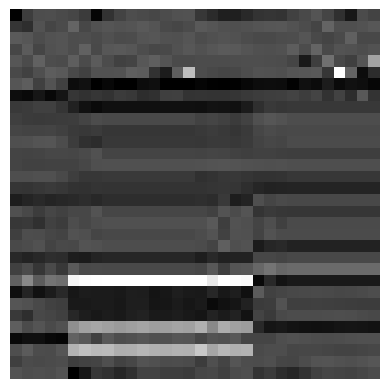

In [19]:
image_path = '/kaggle/working/unsw_nb15/train/normal/image1.jpg'

# Tải hình ảnh
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Ẩn trục
plt.show()

### Kiểm tra số lượng kênh

In [22]:
# Kiểm tra số kênh của ảnh
print("Số chiều của ảnh:", img.ndim)
print("Hình dạng của ảnh:", img.shape)

Số chiều của ảnh: 3
Hình dạng của ảnh: (32, 32, 3)


In [23]:
import torch
import shutil
import numpy as np
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

from transformers import AutoModelForImageClassification, ViTConfig

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

train_dir = "/kaggle/working/unsw_nb15/train/"
test_dir = "/kaggle/working/unsw_nb15/test/"


class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_transforms_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.05),
    transforms.Normalize(mean=mean, std=std)
])


# Dữ liệu gốc từ thư mục
dataset = datasets.ImageFolder(root=train_dir)

# Chia tách dataset thành train và val
train_size = int(0.8 * len(dataset))  # 80% cho train
val_size = len(dataset) - train_size  # 20% cho validation
train_indices, val_indices = random_split(dataset, [train_size, val_size])

# Tạo các tập con với phép biến đổi riêng biệt
train_dataset = Subset(dataset, train_indices.indices)
train_dataset.dataset.transform = train_transforms_rgb

val_dataset = Subset(dataset, val_indices.indices)
val_dataset.dataset.transform = transform_rgb

# Lấy nhãn của các mẫu trong train_dataset
labels_train = [dataset.targets[i] for i in train_indices.indices]
labels_val = [dataset.targets[i] for i in val_indices.indices]

# Tạo DataLoader cho train và val
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataset_test = ImageFolder(root=test_dir, transform=transform_rgb)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

config = ViTConfig.from_pretrained("WinKawaks/vit-small-patch16-224")
config.image_size = (32, 32)
config.patch_size = (8, 8)
config.num_channels = 3
config.num_labels = 10

model = AutoModelForImageClassification.from_config(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Khởi tạo đối tượng dừng khi mô hình bị quá khớp
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Mô hình bị overfiting")

# Hàm đánh giá trên tập test
def evaluate_test_set(test_loader, model):
    model.eval()  # Khởi tạo model đánh giá
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.logits, dim=1)  # Dự đoán lớp
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    return all_labels, all_predictions

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [24]:
# Thêm Dropout vào classification head
model.classifier.dropout = torch.nn.Dropout(p=0.4) # Giữ lại 50% nơ-ron

# Chuyển numpy array thành tensor
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Chuyển sang tensor và chuyển đến device

# Định nghĩa hàm mất mát với trọng số lớp
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

# Thiết lập bộ tối ưu với (lr - tốc độ, weight_decay - Regulation L2, L1)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)  # Bộ tối ưu

# Điều chỉnh tốc độ học (learning rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [26]:
count_0, count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8, count_9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

for i in labels_train:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1
    elif i == 2:
        count_2 += 1
    elif i == 3:
        count_3 += 1
    elif i == 4:
        count_4 += 1
    elif i == 5:
        count_5 += 1
    elif i == 6:
        count_6 += 1
    elif i == 7:
        count_7 += 1
    elif i == 8:
        count_8 += 1
    elif i == 9:
        count_9 += 1
        
print(f"attack: {count_0}")
print(f"normal: {count_1}")
print(f"attack: {count_2}")
print(f"normal: {count_3}")
print(f"attack: {count_4}")
print(f"normal: {count_5}")
print(f"attack: {count_6}")
print(f"normal: {count_7}")
print(f"attack: {count_8}")
print(f"normal: {count_9}")

attack: 2756
normal: 2394
attack: 6436
normal: 8013
attack: 6793
normal: 12031
attack: 14357
normal: 5644
attack: 1985
normal: 951


In [ ]:
count_0, count_1 = 0, 0

for i in labels_val:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1

print(f"attack: {count_0}")
print(f"normal: {count_1}")

In [27]:
print(dataset.classes)

['attack', 'normal']


In [27]:
# Chuyển numpy array thành tensor
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Chuyển sang tensor và chuyển đến device

In [27]:
class_weights

tensor([2.2264, 2.5631, 0.9534, 0.7658, 0.9033, 0.5100, 0.4274, 1.0872, 3.0912,
        6.4522], device='cuda:0')

In [25]:
import time

early_stopping = EarlyStopping(patience = 5, verbose=True)

num_epochs = 30 # Số vòng lặp huấn luyện
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Đặt lại gradient
        outputs = model(images)  # Dự đoán
        loss = criterion(outputs.logits, labels)  # Tính toán mất mát
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    
    # Validation
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Dự đoán
            loss = criterion(outputs.logits, labels)  # Tính toán mất mát
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    end_time = time.time()  # Kết thúc đo thời gian
    
    epoch_duration = end_time - start_time
    print(
        f"Epoch {epoch + 1}/{num_epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
        f"Time: {epoch_duration:.2f}s"
    )

    # Điểu chỉnh tốc độ học (learning rate)
    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
      break

Epoch 1/30 - Train Loss: 0.1893, Train Accuracy: 91.28%, Validation Loss: 0.1538, Validation Accuracy: 93.53%, Time: 207.33s
Epoch 2/30 - Train Loss: 0.1328, Train Accuracy: 93.97%, Validation Loss: 0.1251, Validation Accuracy: 94.54%, Time: 200.45s
Epoch 3/30 - Train Loss: 0.1229, Train Accuracy: 94.36%, Validation Loss: 0.1200, Validation Accuracy: 94.70%, Time: 199.18s
Epoch 4/30 - Train Loss: 0.1173, Train Accuracy: 94.53%, Validation Loss: 0.1088, Validation Accuracy: 94.98%, Time: 198.91s
Epoch 5/30 - Train Loss: 0.1123, Train Accuracy: 94.77%, Validation Loss: 0.1078, Validation Accuracy: 95.12%, Time: 198.37s
Epoch 6/30 - Train Loss: 0.1055, Train Accuracy: 95.00%, Validation Loss: 0.1020, Validation Accuracy: 95.21%, Time: 198.33s
Epoch 7/30 - Train Loss: 0.0994, Train Accuracy: 95.28%, Validation Loss: 0.0970, Validation Accuracy: 95.42%, Time: 198.28s
Epoch 8/30 - Train Loss: 0.0939, Train Accuracy: 95.61%, Validation Loss: 0.0913, Validation Accuracy: 95.57%, Time: 198.50s


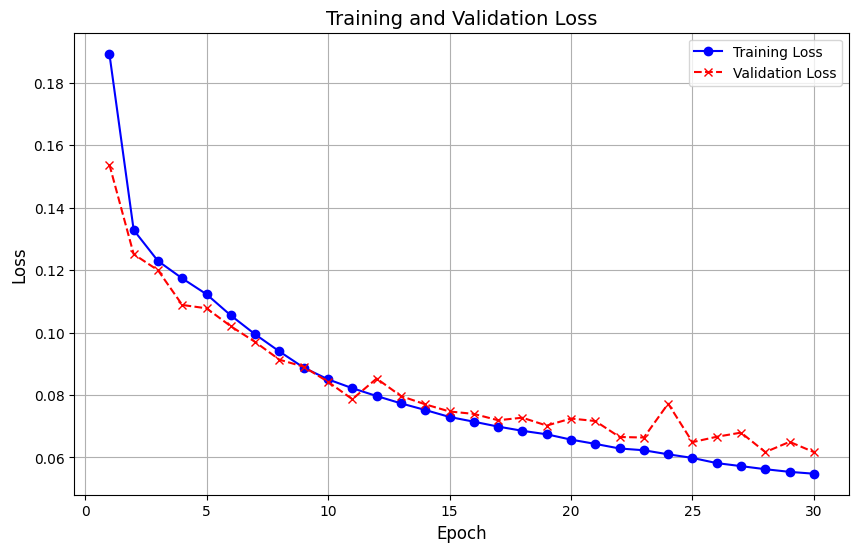

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))

# Vẽ đường cho Training Loss và Validation Loss với điểm đánh dấu
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', color='b')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x', linestyle='--', color='r') 

# Thêm lưới
plt.grid(True)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.title("Training and Validation Loss", fontsize=14)

# Hiển thị chú thích
plt.legend()

plt.show()

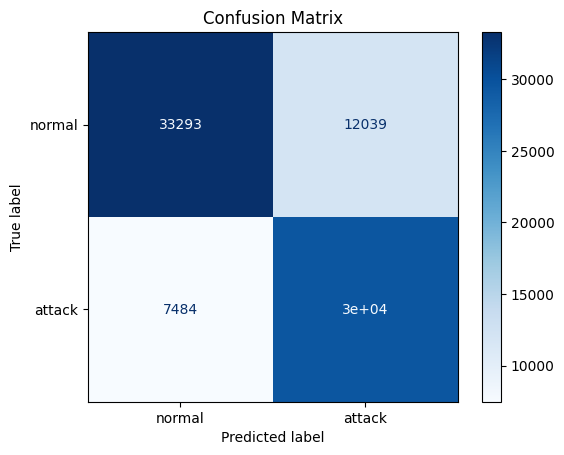

              precision    recall  f1-score   support

      attack       0.82      0.73      0.77     45332
      normal       0.71      0.80      0.75     37000

    accuracy                           0.76     82332
   macro avg       0.76      0.77      0.76     82332
weighted avg       0.77      0.76      0.76     82332



In [27]:
y_true, y_pred = evaluate_test_set(test_loader, model)

# Trực quan hóa Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Đánh giá kiểm thử
print(classification_report(y_true, y_pred, target_names=['attack', 'normal']))

In [28]:
import time

early_stopping = EarlyStopping(patience = 5, verbose=True)

num_epochs = 20 # Số vòng lặp huấn luyện


for epoch in range(num_epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Đặt lại gradient
        outputs = model(images)  # Dự đoán
        loss = criterion(outputs.logits, labels)  # Tính toán mất mát
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Validation
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Dự đoán
            loss = criterion(outputs.logits, labels)  # Tính toán mất mát
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    end_time = time.time()  # Kết thúc đo thời gian
    
    epoch_duration = end_time - start_time
    print(
        f"Epoch {epoch + 1}/{num_epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
        f"Time: {epoch_duration:.2f}s"
    )

    # Điểu chỉnh tốc độ học (learning rate)
    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
      break

Epoch 1/20 - Train Loss: 1.3839, Train Accuracy: 56.28%, Validation Loss: 1.1771, Validation Accuracy: 61.87%, Time: 89.17s
Epoch 2/20 - Train Loss: 1.1398, Train Accuracy: 63.22%, Validation Loss: 1.0815, Validation Accuracy: 65.53%, Time: 87.08s
Epoch 3/20 - Train Loss: 1.0752, Train Accuracy: 64.74%, Validation Loss: 1.0428, Validation Accuracy: 66.28%, Time: 87.58s
Epoch 4/20 - Train Loss: 1.0316, Train Accuracy: 66.35%, Validation Loss: 1.0026, Validation Accuracy: 63.17%, Time: 87.52s
Epoch 5/20 - Train Loss: 1.0019, Train Accuracy: 67.06%, Validation Loss: 0.9874, Validation Accuracy: 68.43%, Time: 87.60s
Epoch 6/20 - Train Loss: 0.9781, Train Accuracy: 68.16%, Validation Loss: 0.9481, Validation Accuracy: 67.95%, Time: 86.56s
Epoch 7/20 - Train Loss: 0.9575, Train Accuracy: 68.94%, Validation Loss: 0.9889, Validation Accuracy: 70.36%, Time: 86.92s
Epoch 8/20 - Train Loss: 0.9419, Train Accuracy: 69.28%, Validation Loss: 0.9342, Validation Accuracy: 71.50%, Time: 87.92s
Epoch 9/

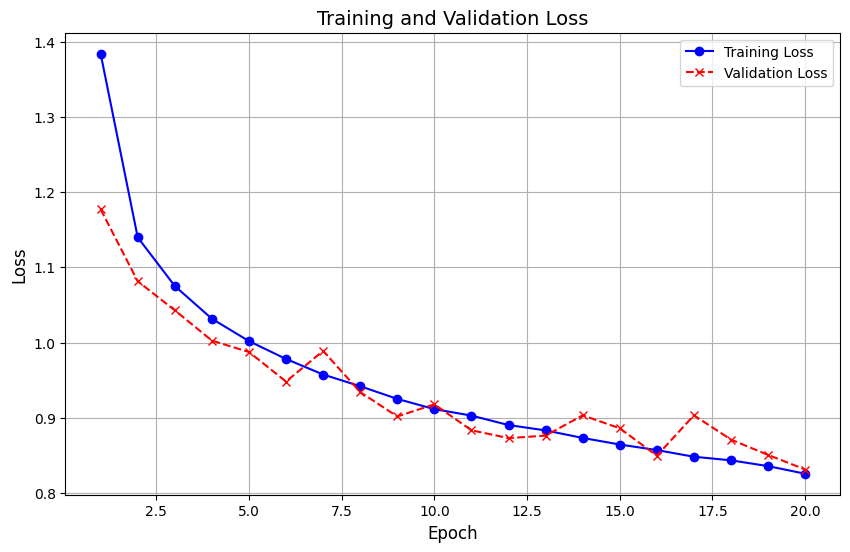

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))

# Vẽ đường cho Training Loss và Validation Loss với điểm đánh dấu
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', color='b')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x', linestyle='--', color='r') 

# Thêm lưới
plt.grid(True)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.title("Training and Validation Loss", fontsize=14)

# Hiển thị chú thích
plt.legend()

plt.show()

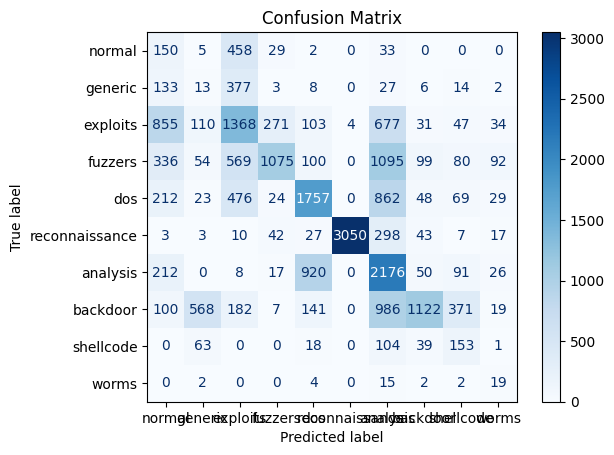

                precision    recall  f1-score   support

         worms       0.07      0.22      0.11       677
     shellcode       0.02      0.02      0.02       583
      backdoor       0.40      0.39      0.39      3500
      analysis       0.73      0.31      0.43      3500
reconnaissance       0.57      0.50      0.53      3500
           dos       1.00      0.87      0.93      3500
       fuzzers       0.35      0.62      0.45      3500
      exploits       0.78      0.32      0.45      3496
       generic       0.18      0.40      0.25       378
        normal       0.08      0.43      0.13        44

      accuracy                           0.48     22678
     macro avg       0.42      0.41      0.37     22678
  weighted avg       0.60      0.48      0.50     22678



In [30]:
y_true, y_pred = evaluate_test_set(test_loader, model)

# Trực quan hóa Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'generic', 'exploits', 'fuzzers', 'dos', 
                                                                   'reconnaissance', 'analysis', 'backdoor', 'shellcode', 'worms'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Đánh giá kiểm thử
print(classification_report(y_true, y_pred, target_names=['worms', 'shellcode', 'backdoor', 'analysis', 'reconnaissance', 
                                                                   'dos', 'fuzzers', 'exploits', 'generic', 'normal'], zero_division=0))